In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import shap


In [ ]:
df_orders=pd.read_csv('/content/drive/MyDrive/CLV/olist_orders_dataset.csv')
df_payments=pd.read_csv('/content/drive/MyDrive/CLV/olist_order_payments_dataset.csv')
df_items=pd.read_csv('/content/drive/MyDrive/CLV/olist_order_items_dataset.csv')

# Data Cleaning

In [ ]:
df_orders.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [ ]:
df_items.head(5)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [ ]:
df_payments.head(5)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [ ]:
# 1. select the nessary colunms
orders = df_orders[['order_id', 'customer_id', 'order_purchase_timestamp']]
items = df_items[['order_id', 'product_id', 'seller_id']]
payments = df_payments[['order_id', 'payment_value']]


# merge three tables
merged = orders.merge(items, on='order_id').merge(payments, on='order_id')

In [ ]:
merged.head(5)

,order_id,customer_id,order_purchase_timestamp,product_id,seller_id,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,179.12


In [ ]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117601 entries, 0 to 117600
Data columns (total 6 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   order_id                  117601 non-null  object 
 1   customer_id               117601 non-null  object 
 2   order_purchase_timestamp  117601 non-null  object 
 3   product_id                117601 non-null  object 
 4   seller_id                 117601 non-null  object 
 5   payment_value             117601 non-null  float64
dtypes: float64(1), object(5)
memory usage: 5.4+ MB


In [ ]:
merged.isnull().sum()

,0
order_id,0
customer_id,0
order_purchase_timestamp,0
product_id,0
seller_id,0
payment_value,0


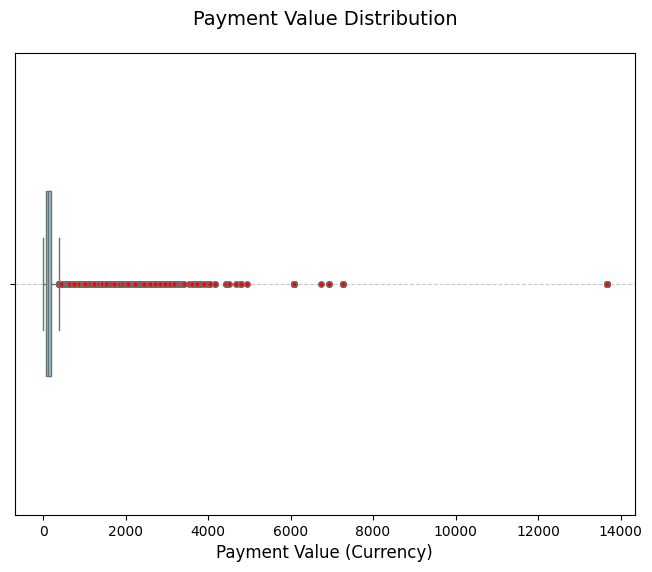

In [ ]:
#payment value distrubution

plt.figure(figsize=(8, 6))

sns.boxplot(
    x=merged['payment_value'],
    width=0.4,
    color='skyblue',
    flierprops={'marker': 'o', 'markersize': 4, 'markerfacecolor':'red'}  # 异常值样式
)

plt.title('Payment Value Distribution', fontsize=14, pad=20)
plt.xlabel('Payment Value (Currency)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [ ]:
print(f"Median: {merged['payment_value'].median()}")
print(f"Average: {merged['payment_value'].mean()}")

Median: 108.21
Average: 172.6867518983682


In [ ]:
# top 10 high value orders
high_payments = merged.nlargest(10, 'payment_value')
print(high_payments[['order_id', 'payment_value']])

                               order_id  payment_value
15709  03caa2c082116e1d31e67e9ae3700499       13664.08
15710  03caa2c082116e1d31e67e9ae3700499       13664.08
15711  03caa2c082116e1d31e67e9ae3700499       13664.08
15712  03caa2c082116e1d31e67e9ae3700499       13664.08
15713  03caa2c082116e1d31e67e9ae3700499       13664.08
15714  03caa2c082116e1d31e67e9ae3700499       13664.08
15715  03caa2c082116e1d31e67e9ae3700499       13664.08
15716  03caa2c082116e1d31e67e9ae3700499       13664.08
78641  736e1922ae60d0d6a89247b851902527        7274.88
78642  736e1922ae60d0d6a89247b851902527        7274.88


In [ ]:


# ensure data type as datatime
merged['order_purchase_timestamp'] = pd.to_datetime(merged['order_purchase_timestamp'])

# set the latest data as current date
current_date = merged['order_purchase_timestamp'].max()

# aggregate RFM
rfm = merged.groupby('customer_id').agg({
    # Recency：the most recent purchase
    'order_purchase_timestamp': lambda x: (current_date - x.max()).days,

    # Frequency：histrical orders count(Distinct)
    'order_id': pd.Series.nunique,

    # Monetary：total purchase value
    'payment_value': 'sum'
}).reset_index()

# rename columns
rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']

# print data types and results
print(rfm.dtypes)
print(rfm.head())

customer_id     object
recency          int64
frequency        int64
monetary       float64
dtype: object
                        customer_id  recency  frequency  monetary
0  00012a2ce6f8dcda20d059ce98491703      292          1    114.74
1  000161a058600d5901f007fab4c27140      413          1     67.41
2  0001fd6190edaaf884bcaf3d49edf079      551          1    195.42
3  0002414f95344307404f0ace7a26f1d5      382          1    179.35
4  000379cdec625522490c315e70c7a9fb      153          1    107.01


In [ ]:
# data distribution
print(rfm.describe())

            recency  frequency       monetary
count  98665.000000    98665.0   98665.000000
mean     244.811017        1.0     205.829166
std      153.386320        0.0     620.729403
min        0.000000        1.0       9.590000
25%      121.000000        1.0      62.700000
50%      226.000000        1.0     109.680000
75%      355.000000        1.0     195.910000
max      728.000000        1.0  109312.640000


In [ ]:
# handle outliner (keep under 99% quantile data)
for col in ['recency', 'frequency', 'monetary']:
    q_high = rfm[col].quantile(0.99)
    rfm = rfm[rfm[col] <= q_high]

# natural log transformation
rfm['monetary_log'] = np.log1p(rfm['monetary'])

To normalize the distribution and minimize the influence of outliers, we applied a natural log transformation using `np.log1p()` on the monetary  variable.

# Standarization

In [ ]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['recency', 'frequency', 'monetary_log']])
rfm_scaled = pd.DataFrame(rfm_scaled, columns=['recency', 'frequency', 'monetary'])

# The Elbow method

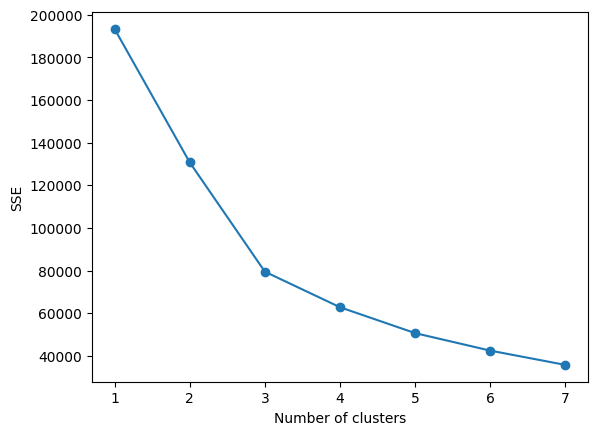

In [ ]:
# The Elbow method to identify K
sse = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(1,8), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

As above plot shows, number three is the optimal number of K-means cluster. Because the graph shows rapid changed when x axis = 3, it means WCSS begins to decrease more slowly. So number three is the optimal k value.

# Silhouette Analysis

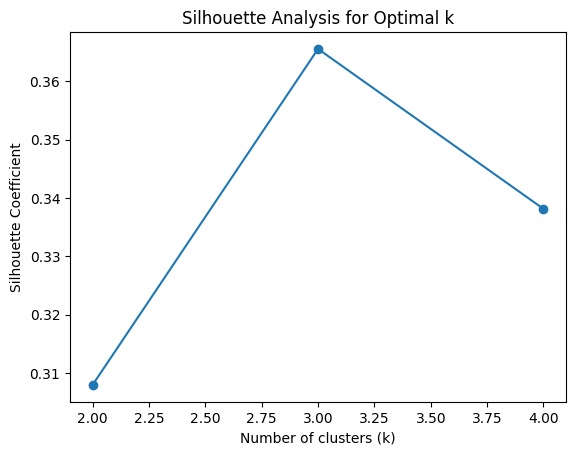

In [ ]:
#silhouette analysis
sil_scores = []
k_range = range(2, 5)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    sil_scores.append(score)

# plot
plt.plot(k_range, sil_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Analysis for Optimal k')
plt.show()

The silhouette analysis shows that k=3 yields the highest silhouette score (~0.367), indicating that three clusters provide the most well-separated and cohesive grouping structure in the data.

# K-means model trainning

In [ ]:
# choose k= 3 for clustering
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['cluster'] = kmeans.fit_predict(rfm_scaled)

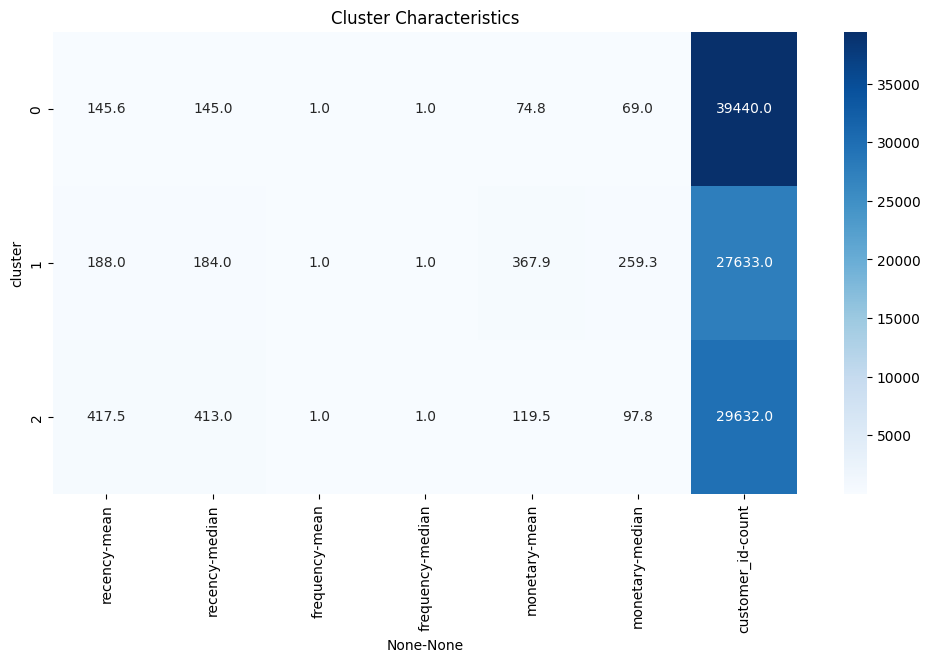

In [ ]:
# each cluster feature analysis
cluster_profile = rfm.groupby('cluster').agg({
    'recency': ['mean', 'median'],
    'frequency': ['mean', 'median'],
    'monetary': ['mean', 'median'],
    'customer_id': 'count'
}).reset_index()

# Visulise Clusters
plt.figure(figsize=(12,6))
sns.heatmap(cluster_profile.set_index('cluster'), annot=True, fmt=".1f", cmap='Blues')
plt.title('Cluster Characteristics')
plt.show()

# Label High, Middle, and Low Value Customer
rfm['value_segment'] = np.where(
    rfm['cluster'] == 1, 'High Value',
    np.where(rfm['cluster'] == 2, 'Middle Value', 'Low Value')
)

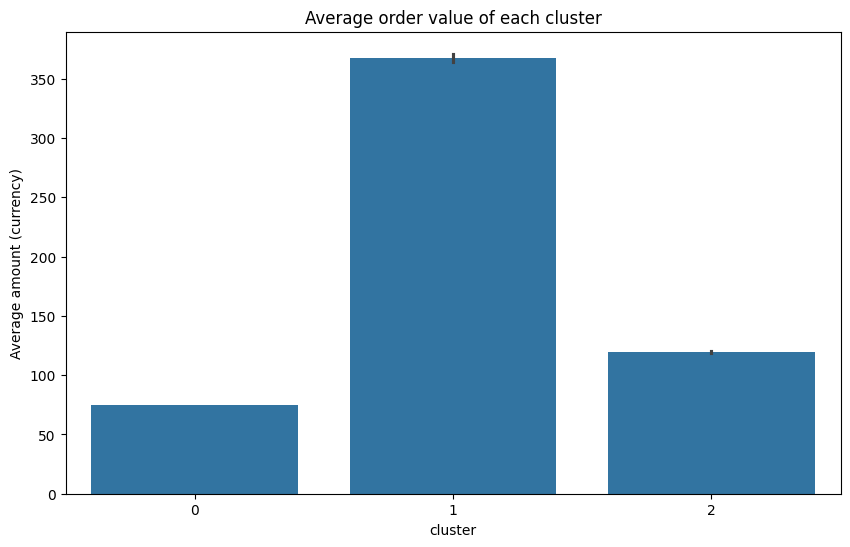

In [ ]:

plt.figure(figsize=(10,6))
sns.barplot(x='cluster', y='monetary', data=rfm, estimator=np.mean)
plt.title('Average order value of each cluster')
plt.ylabel('Average amount (currency)')
plt.show()

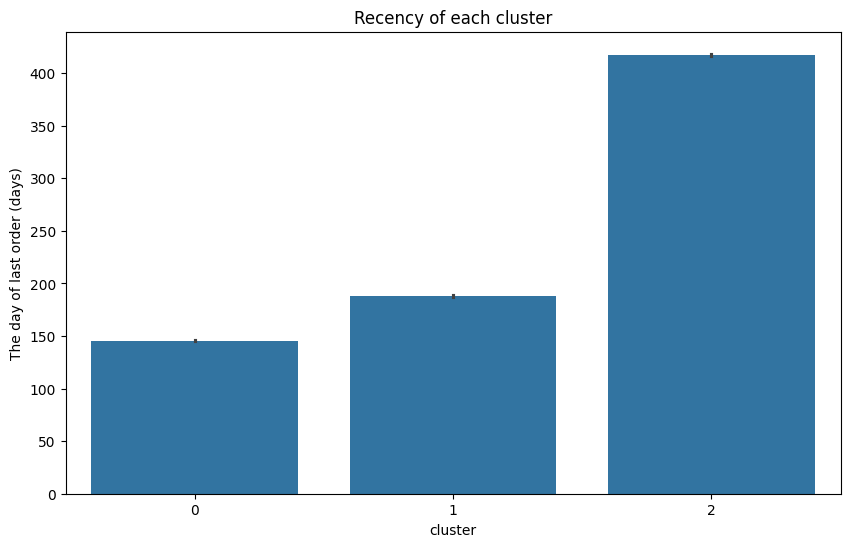

In [ ]:

plt.figure(figsize=(10,6))
sns.barplot(x='cluster', y='recency', data=rfm, estimator=np.mean)
plt.title('Recency of each cluster')
plt.ylabel('The day of last order (days)')
plt.show()

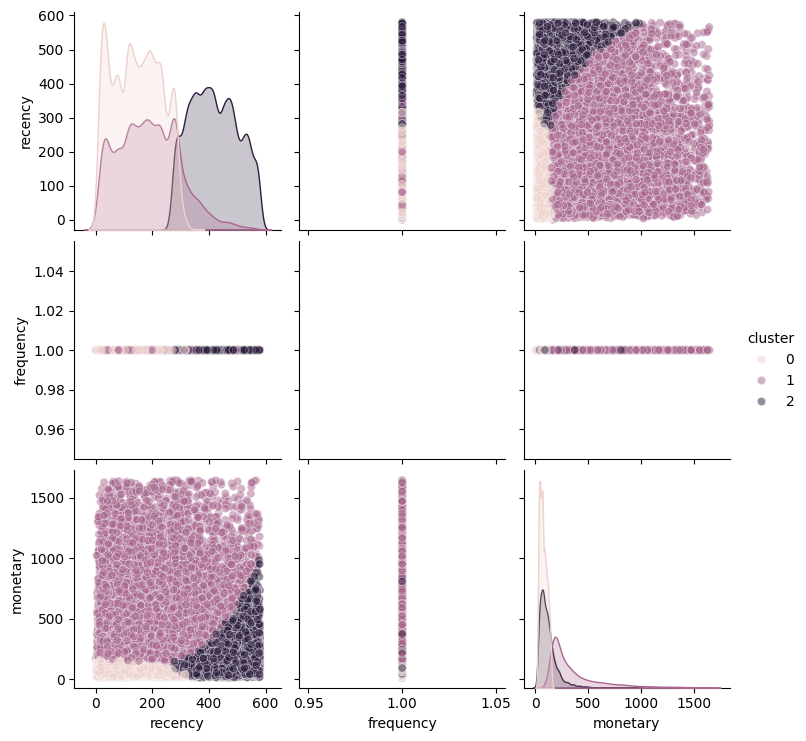

In [ ]:
sns.pairplot(rfm[['recency', 'frequency', 'monetary', 'cluster']],
             hue='cluster', plot_kws={'alpha':0.5})

In [ ]:
rfm.head(5)

,customer_id,recency,frequency,monetary,monetary_log,cluster,value_segment
0,00012a2ce6f8dcda20d059ce98491703,292,1,114.74,4.751346,2,Middle Value
1,000161a058600d5901f007fab4c27140,413,1,67.41,4.225519,2,Middle Value
2,0001fd6190edaaf884bcaf3d49edf079,551,1,195.42,5.280255,2,Middle Value
3,0002414f95344307404f0ace7a26f1d5,382,1,179.35,5.194899,2,Middle Value
4,000379cdec625522490c315e70c7a9fb,153,1,107.01,4.682224,0,Low Value


# Features Engineering

In [ ]:
# create new features
rfm["recency_freq_ratio"] = rfm["recency"] / (rfm["frequency"] + 1e-6)
rfm["monetary_per_order"] = rfm["monetary"] / rfm["frequency"]

# define features and target variables
features = ['recency', 'frequency', 'monetary',
           'recency_freq_ratio', 'monetary_per_order']
X = rfm[features]
y = rfm['cluster']  # target variables

# handle class inbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# split train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# Model Training

In [ ]:
# Random forest model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train, y_train)

# XGBoost model
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    objective='multi:softmax'
)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

# Models Evaluation

Random Forest classification report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      7912
           1       0.99      0.99      0.99      7843
           2       0.98      0.99      0.99      7909

    accuracy                           0.99     23664
   macro avg       0.99      0.99      0.99     23664
weighted avg       0.99      0.99      0.99     23664

XGBoost classification report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7912
           1       0.99      1.00      0.99      7843
           2       0.99      1.00      0.99      7909

    accuracy                           1.00     23664
   macro avg       1.00      1.00      1.00     23664
weighted avg       1.00      1.00      1.00     23664



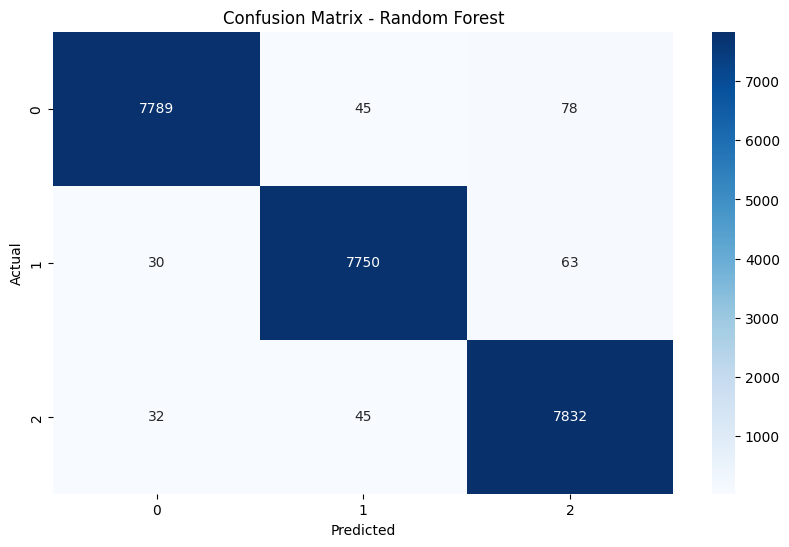

In [ ]:

# Random Forest model evaluation
y_pred_rf = rf_model.predict(X_test)
print("Random Forest classification report:")
print(classification_report(y_test, y_pred_rf))

# XGBoost model evaluation
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost classification report:")
print(classification_report(y_test, y_pred_xgb))

# confusion matrix

plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf),
           annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

While the classification accuracy is very high (~99-100%), there’s a risk of overfitting, especially since the target labels come from unsupervised clustering. To verify generalization, we should evaluate on a hold-out test set and/or perform cross-validation. Model simplification or regularization may also help mitigate overfitting.

# Cross Validation

In [ ]:
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='f1_macro')
print(f"Random Forest CV F1 avg: {np.mean(cv_scores):.4f}")

Random Forest CV F1 avg: 0.9861


In [ ]:
cv_scores_xgb = cross_val_score(xgb_model, X, y, cv=5, scoring='f1_macro')
print(f"XGBoost CV F1 avg: {np.mean(cv_scores_xgb):.4f}")

XGBoost CV F1 avg: 0.9944


We carefully controlled the model complexity using parameters like max_depth and learning_rate. The model performs exceptionally well on both training and test data, which suggests that the underlying clusters are clearly separable rather than the model being overfitted. We further validated this through cross-validation to ensure generalization.

# Features Importance Expaination

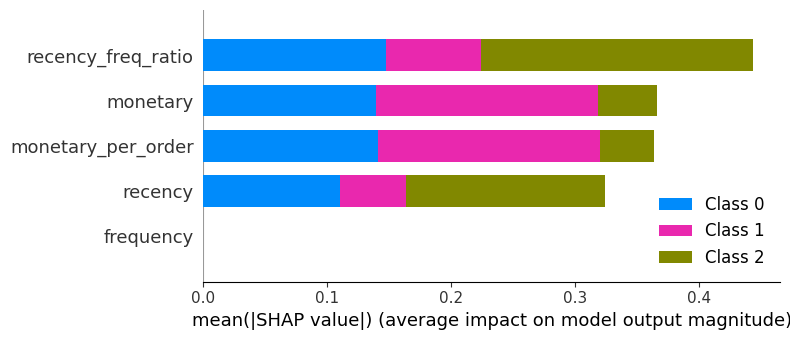

In [ ]:
# random forest features importances
feat_importances = pd.Series(rf_model.feature_importances_, index=features)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importance - Random Forest')

# SHAP explain analysis
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Marketing Application

In [ ]:
def predict_customer_value(new_data):
    """
    Input: data with recency, frequency, and monetary
    Output: value segment and probability

    """
    # Feature Engineering）
    new_data["recency_freq_ratio"] = new_data["recency"] / (new_data["frequency"] + 1e-6)
    new_data["monetary_per_order"] = new_data["monetary"] / new_data["frequency"]

    # prediction
    proba = rf_model.predict_proba(new_data[features])[0]
    class_idx = np.argmax(proba)
    return {
        "segment": rf_model.classes_[class_idx],
        "probability": round(proba[class_idx], 2),
        "details": dict(zip(rf_model.classes_, np.round(proba, 2)))
    }

# Example
new_customer = pd.DataFrame([{
    'recency': 45,
    'frequency': 8,
    'monetary': 4200
}])
print(predict_customer_value(new_customer))


{'segment': np.int32(1), 'probability': np.float64(0.99), 'details': {np.int32(0): np.float64(0.01), np.int32(1): np.float64(0.99), np.int32(2): np.float64(0.0)}}


In [ ]:
# Define cluster lables
cluster_map = {
    0: 'Low Value Customer',
    1: 'High Value Customer',
    2: 'Mid Value Customer'
}


rfm['value_segment'] = rfm['cluster'].map(cluster_map)

# define marketing action
strategy_map = {
    'High Value Customer': 'Upsell',
    'Mid Value Customer': 'Crosssell',
    'Low Value Customer': 'Discount + Churn Alert'
}

# New Strategy Column
rfm['recommended_strategy'] = rfm['value_segment'].map(strategy_map)

In [ ]:
print(rfm.columns.tolist())

['customer_id', 'recency', 'frequency', 'monetary', 'monetary_log', 'cluster', 'value_segment', 'recency_freq_ratio', 'monetary_per_order', 'recommended_strategy']


In [ ]:
# print sample data
print(rfm[['customer_id', 'cluster', 'value_segment', 'recommended_strategy']].head(3))

                        customer_id  cluster       value_segment  \
0  00012a2ce6f8dcda20d059ce98491703        2  Mid Value Customer   
1  000161a058600d5901f007fab4c27140        2  Mid Value Customer   
2  0001fd6190edaaf884bcaf3d49edf079        2  Mid Value Customer   

  recommended_strategy  
0            Crosssell  
1            Crosssell  
2            Crosssell  
